In [38]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Definisanje fuzzy ulaza
#udaljenost od prepreke
distance_to_obstacle = ctrl.Antecedent(np.arange(0, 101, 1), 'distance_to_obstacle')
# udaljenost do cilja 
distance_to_target = ctrl.Antecedent(np.arange(0, 101, 1), 'distance_to_target')
# greska između trenutnog ugla putanje i ugla cilja
angle_error = ctrl.Antecedent(np.arange(-180, 181, 1), 'angle_error')

# Definisanje fuzzy izlaza
# promena brzina
speed_change = ctrl.Consequent(np.arange(-100, 101, 1), 'speed_change')
# promena ugla
heading_change = ctrl.Consequent(np.arange(-45, 46, 1), 'heading_change')

# Definisanje funkcija pripadnosti za udaljenost do prepreke
# nema blizu 
distance_to_obstacle['far'] = fuzz.trimf(distance_to_obstacle.universe, [50, 100, 100])
distance_to_obstacle['very_far'] = fuzz.trimf(distance_to_obstacle.universe, [80, 100, 100])

# Definisanje funkcija pripadnosti za udaljenost do cilja
distance_to_target['on_top'] = fuzz.trimf(distance_to_target.universe, [0, 0, 20])
distance_to_target['medium'] = fuzz.trimf(distance_to_target.universe, [20, 50, 80])
distance_to_target['far'] = fuzz.trimf(distance_to_target.universe, [50, 100, 100])

# Definisanje funkcija pripadnosti za grešku u uglu
angle_error['neg_big'] = fuzz.trimf(angle_error.universe, [-180, -180, -90])
angle_error['neg_med'] = fuzz.trimf(angle_error.universe, [-90, -45, 0])
angle_error['neg_small'] = fuzz.trimf(angle_error.universe, [-30, -10, 0])
angle_error['zero'] = fuzz.trimf(angle_error.universe, [-1, 0, 1])
angle_error['pos_small'] = fuzz.trimf(angle_error.universe, [0, 10, 30])
angle_error['pos_med'] = fuzz.trimf(angle_error.universe, [30, 90, 120])
angle_error['pos_big'] = fuzz.trimf(angle_error.universe, [90, 180, 180])

# Definisanje funkcija pripadnosti za promenu brzine (Speed Change)
speed_change['very_slow'] = fuzz.trimf(speed_change.universe, [-100, -100, -50])
speed_change['slow'] = fuzz.trimf(speed_change.universe, [-50, 0, 50])
speed_change['fast'] = fuzz.trimf(speed_change.universe, [50, 100, 100])
speed_change['very_fast'] = fuzz.trimf(speed_change.universe, [75, 100, 100])

# Definisanje funkcija pripadnosti za promenu ugla pravca (Heading Change)
heading_change['neg_big'] = fuzz.trimf(heading_change.universe, [-45, -45, -15])
heading_change['neg_med'] = fuzz.trimf(heading_change.universe, [-15, -10, 0])
heading_change['neg_small'] = fuzz.trimf(heading_change.universe, [-5, 0, 0])
heading_change['zero'] = fuzz.trimf(heading_change.universe, [-1, 0, 1])
heading_change['pos_small'] = fuzz.trimf(heading_change.universe, [0, 5, 15])
heading_change['pos_med'] = fuzz.trimf(heading_change.universe, [10, 15, 45])
heading_change['pos_big'] = fuzz.trimf(heading_change.universe, [15, 45, 45])

# Pravila fuzzy sistema bez prepreka (na osnovu pravila koje si poslao)
rule1 = ctrl.Rule(distance_to_obstacle['very_far'] & distance_to_target['far'], 
                  (speed_change['fast'], heading_change['zero']))
rule2 = ctrl.Rule(distance_to_obstacle['very_far'] & distance_to_target['medium'], 
                  (speed_change['slow'], heading_change['zero']))
rule3 = ctrl.Rule(distance_to_obstacle['very_far'] & distance_to_target['on_top'], 
                  (speed_change['very_slow'], heading_change['zero']))

rule4 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['neg_big'], 
                  (speed_change['fast'], heading_change['neg_big']))
rule5 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['neg_med'], 
                  (speed_change['slow'], heading_change['neg_med']))
rule6 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['neg_small'], 
                  (speed_change['slow'], heading_change['neg_small']))

rule7 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['zero'], 
                  (speed_change['fast'], heading_change['zero']))
rule8 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['pos_small'], 
                  (speed_change['slow'], heading_change['pos_small']))
rule9 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['pos_med'], 
                  (speed_change['slow'], heading_change['pos_med']))
rule10 = ctrl.Rule(distance_to_obstacle['very_far'] & angle_error['pos_big'], 
                   (speed_change['fast'], heading_change['pos_big']))

# Kreiranje fuzzy sistema
uav_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10])
uav_simulation = ctrl.ControlSystemSimulation(uav_ctrl)

# Primer ulaza
uav_simulation.input['distance_to_obstacle'] = 90  # udaljenost do prepreke (veoma daleko)
uav_simulation.input['distance_to_target'] = 75    # udaljenost do cilja (daleko)
uav_simulation.input['angle_error'] = 45           # greška u uglu (pozitivna greška)

# Izvršavanje fuzzy sistema
uav_simulation.compute()

# Ispis rezultata simulacije
print(f"Predložena promena brzine: {uav_simulation.output['speed_change']:.2f}")
print(f"Predložena promena ugla pravca: {uav_simulation.output['heading_change']:.2f}")






Predložena promena brzine: 37.18
Predložena promena ugla pravca: 23.69


In [30]:
# fig, axs = plt.subplots(nrows=4, figsize=(10, 12))

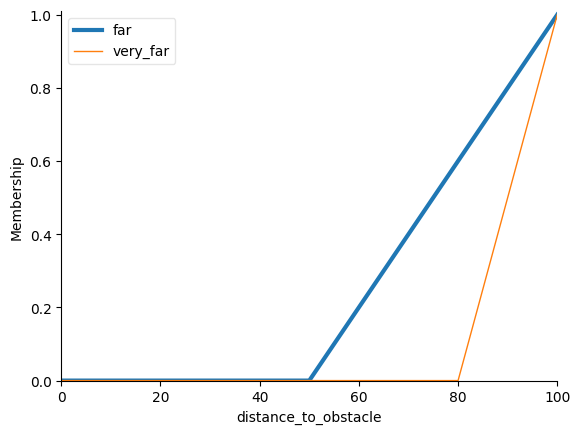

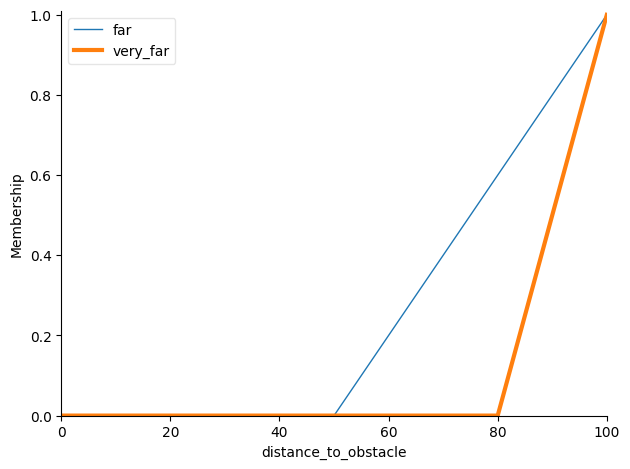

In [31]:
# Distance to Obstacle
distance_to_obstacle['far'].view(ax=axs[0])
distance_to_obstacle['very_far'].view(ax=axs[0])
axs[0].set_title('Distance to Obstacle')

plt.tight_layout()
plt.show()

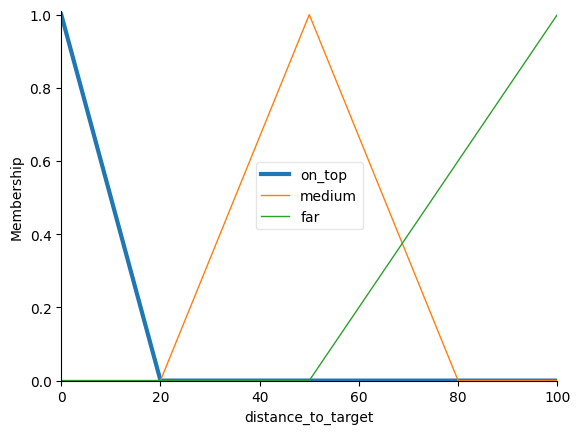

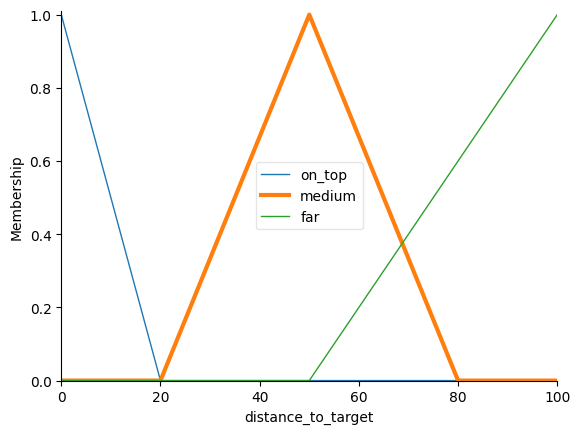

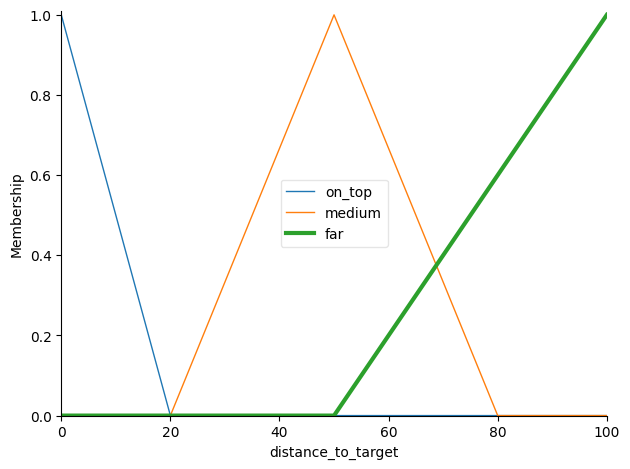

In [35]:
# Distance to Target
distance_to_target['on_top'].view(ax=axs[1])
distance_to_target['medium'].view(ax=axs[1])
distance_to_target['far'].view(ax=axs[1])
axs[1].set_title('Distance to Target')

plt.tight_layout()
plt.show()

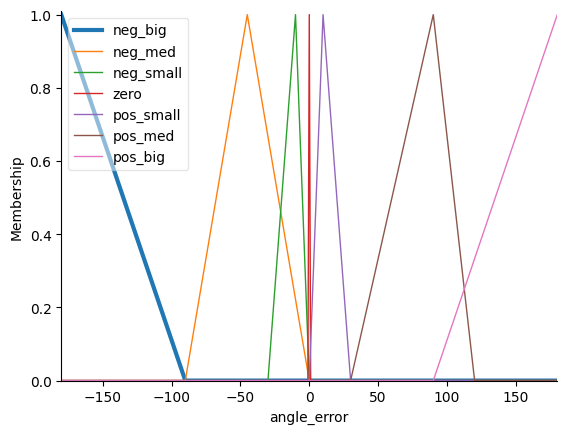

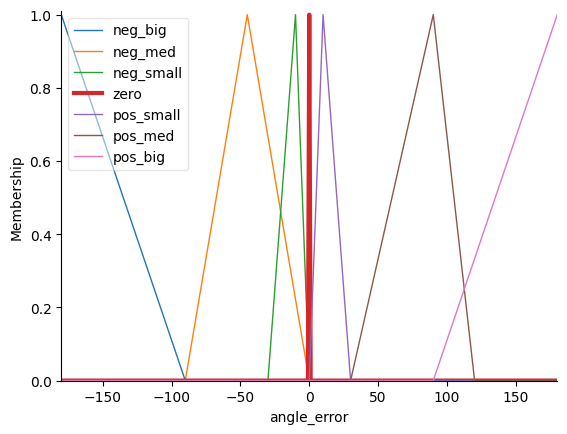

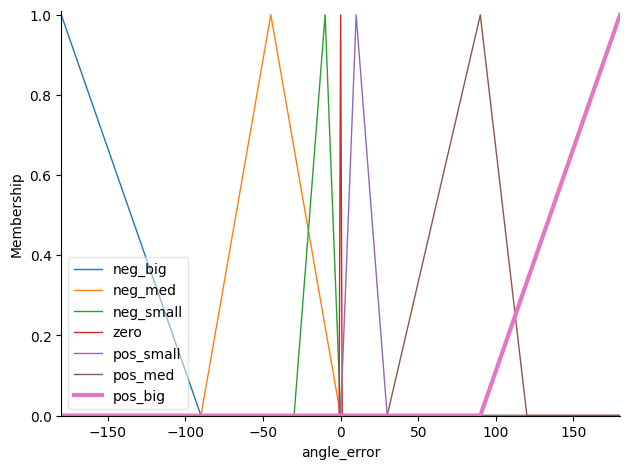

In [36]:
# Angle Error
angle_error['neg_big'].view(ax=axs[2])
angle_error['zero'].view(ax=axs[2])
angle_error['pos_big'].view(ax=axs[2])
axs[2].set_title('Angle Error')

plt.tight_layout()
plt.show()

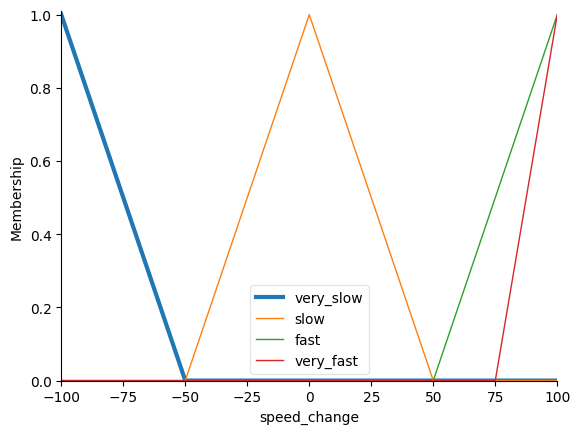

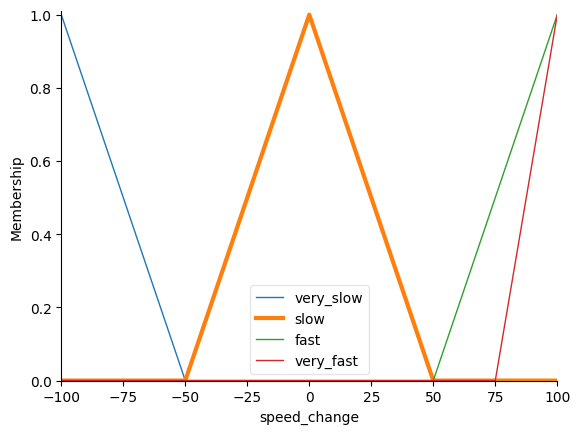

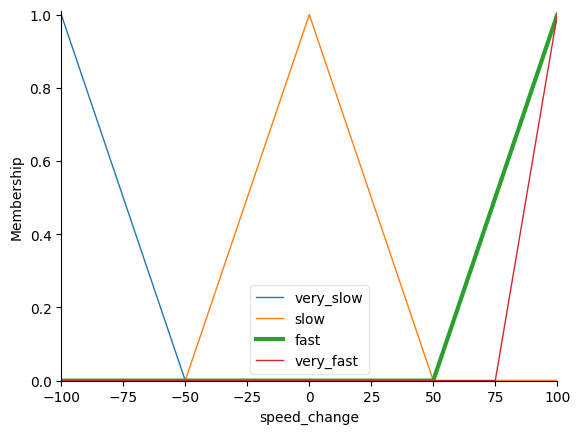

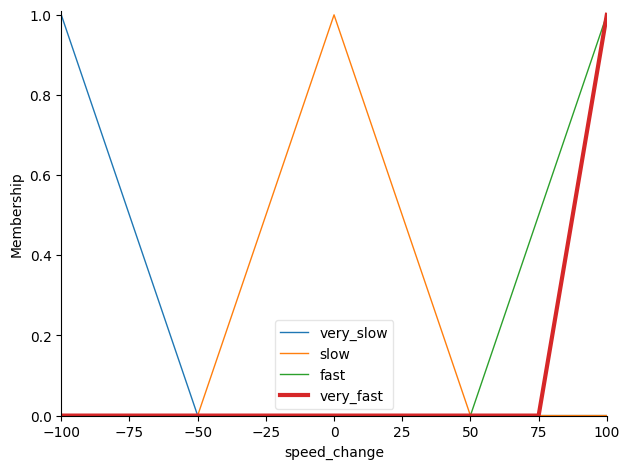

In [37]:
# Speed Change
speed_change['very_slow'].view(ax=axs[3])
speed_change['slow'].view(ax=axs[3])
speed_change['fast'].view(ax=axs[3])
speed_change['very_fast'].view(ax=axs[3])
axs[3].set_title('Speed Change')

plt.tight_layout()
plt.show()